In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.facecolor'] = 'white'

np.random.seed(1)

In [3]:
def pad_images(images, pad_size, pad_value=0):
    '''Pad with the given value all images of inputs(a batch of image).
    The padding is applied to the height and weight of each image.

    - Args
        images: A batch of m-images of shape (m, n_h_pixels, n_w_pixels, n_channels)
        pad_size: Size of padding around each image on vertical and horizontal dimensions
        pad_value: Value to pad images; default 0

    - Returns
        Zero-padded m-images of shape (m, n_h_pixels + 2*pad, n_w_pixels + 2*pad, n_channels)
    '''
    padded_images = np.pad(images,
                           pad_width=((0, 0), (pad_size, pad_size), (pad_size, pad_size), (0, 0)),
                           mode='constant',
                           constant_values=(pad_value, pad_value))
    return padded_images

images.shape=(4, 3, 3, 2)
padded_images.shape=(4, 7, 7, 2)


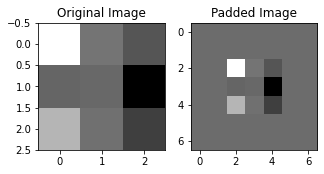

In [4]:
np.random.seed(3)
images = np.random.randn(4, 3, 3, 2)
padded_images = pad_images(images, 2)

assert images.shape == (4, 3, 3, 2)
assert padded_images.shape == (4, 7, 7, 2)

print(f'images.shape={images.shape}')
print(f'padded_images.shape={padded_images.shape}')

figure, axes = plt.subplots(1, 2)

image = images[0, :, :, 0]
axes[0].set_title('Original Image')
axes[0].imshow(image)

padded_image = padded_images[0, :, :, 0]
axes[1].set_title('Padded Image')
axes[1].imshow(padded_image)
plt.show()

In [5]:
def conv_step(patch_rev, weights, bias):
    z = np.multiply(patch_prev, weights)
    z = np.sum(z)
    z = z + float(bias)

    return z

In [6]:
def conv_step(patch_prev, weights, bias):
    '''Perform convolution operation using a filter defined by weights on a patch
    of the output activation of the previous layer.

    - Args
        patch_prev: A patch(slice) of the input volume
                    of shape (filter_size, filter_size, n_channels_prev)
        weights: Weights contained in a window(tensor)
                 of shape (filter_size, filter_size, n_channels_prev)
        bias: Bias contained in a window of shape (1, 1, 1)

    - Returns
        z; a scalar.
        The result of convoluation operation on the given patch with weights and bias
    '''
    z = np.multiply(patch_prev, weights) # element-wise product
    z = np.sum(z) # add all elements; complete the convolution operation
    z = z + float(bias)

    return z

In [7]:
np.random.seed(1)
patch_prev = np.random.randn(4, 4, 3)
weights = np.random.randn(4, 4, 3)
bias = np.random.randn(1, 1, 1)

z = conv_step(patch_prev, weights, bias)
print(f'z = {z}')

z = -6.999089450680221


In [8]:
np.random.seed(1)
patch_prev = np.random.randn(4, 4, 3)
weights = np.random.randn(4, 4, 3)
bias = np.random.randn(1, 1, 1)

z = conv_step(patch_prev, weights, bias)
print(f'z = {z}')

z = -6.999089450680221


In [9]:
def conv_forward(A_prev, weights, bias, hparams):
    '''Forward propagation for a convolution function.

    - Args
        A_prev: Output activations of the previous layer
                         of shape (m, n_h_pixels_prev, n_w_pixels_prev, n_channels_prev)
        weights: Weights of shape (filter_size, filter_size, n_channels_prev, n_channels)
        bias: Biases of shape (1, 1, 1, n_channels)
        hparams: A dict containing the hyperparameters "stride", "pad_size", "pad_value"

    - Returns
        Z: The results of convolution operation of shape (m, n_h_pixels, n_w_pixels, n_channels)
        chache: Cache of values needed for the backpropagation of convolution operation
    '''
    (m, n_h_pixels_prev, n_w_pixels_prev, n_channels_prev) = A_prev.shape
    (filter_size, filter_size, n_channels_prev, n_channels) = weights.shape
    
    stride = hparams['stride']
    pad_size = hparams['pad_size']
    pad_value = hparams['pad_value']

    n_h_pixels = ((n_h_pixels_prev + 2*pad_size - filter_size) // stride) + 1
    n_w_pixels = ((n_w_pixels_prev + 2*pad_size - filter_size) // stride) + 1
    
    Z = np.zeros((m, n_h_pixels, n_w_pixels, n_channels))

    padded_A_prev = np.pad(A_prev,
                            pad_width=((0, 0),
                            (pad_size, pad_size),
                            (pad_size, pad_size),
                            (0, 0)),
                            mode='constant',
                            constant_values=(pad_value, pad_value))
    
    for i in range(m):
        padded_a_prev = padded_A_prev[i]
        for h in range(n_h_pixels):
            vertical_start = h * stride
            vertical_end = vertical_start + filter_size
            for w in range(n_w_pixels):
                horizontal_start = w * stride
                horizontal_end = horizontal_start + filter_size
                for c in range(n_channels):
                    a_patch_prev = padded_a_prev[vertical_start:vertical_end, horizontal_start:horizontal_end, :]
                    weight = weights[:, :, :, c]
                    bias = biases[:, :, :, c]
                    z = np.multiply(a_patch_prev, weight)
                    z = np.sum(z) + float(bias)
                    Z[i, h, w, c] = z

    assert(Z.shape == (m, n_h_pixels, n_w_pixels, n_channels))
    cache = (A_prev, weights, biases, hparams)
    
    return Z, cache